Part 2 Demonstration:
True anomaly on 2025.0 (radians): 3.07192


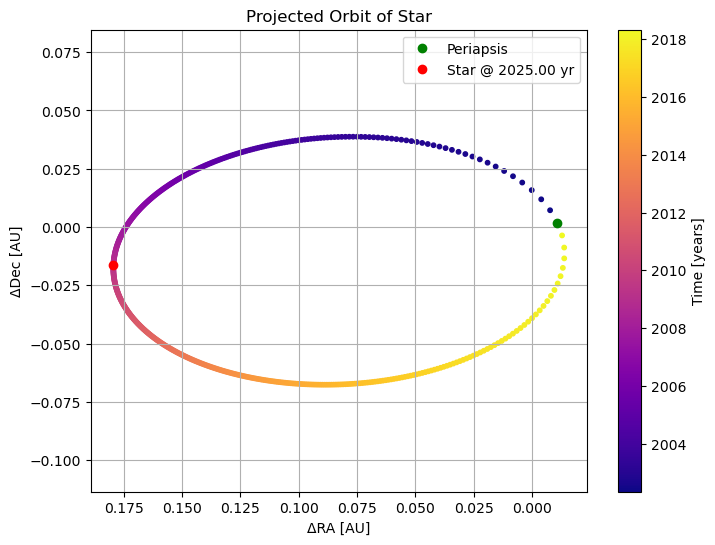


Running MCMC with 16 walkers and 8 dimensions...


100%|██████████| 10000/10000 [27:20<00:00,  6.09it/s]


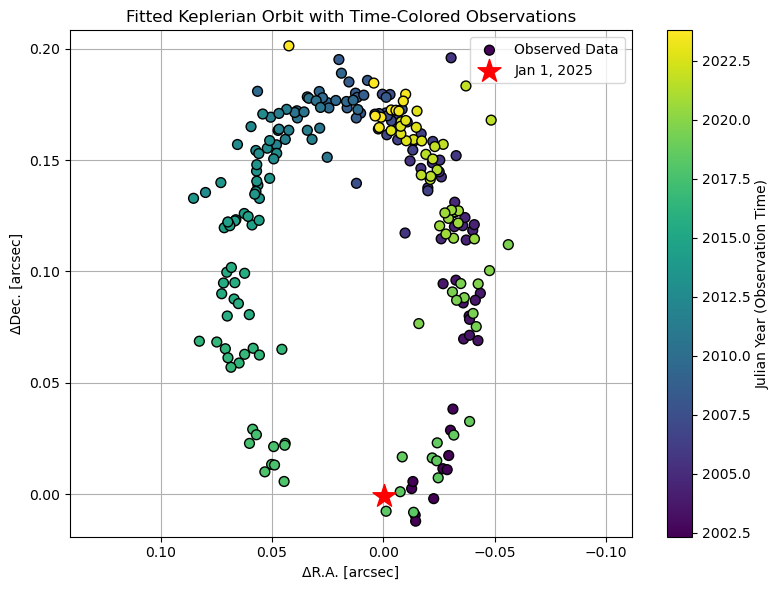


Inferred Parameters (from MCMC Fit):
Mass of Sgr A*: 4.00e+06 Msun
Distance to Sgr A*: 8.00 kpc
Semi-major axis a = 15.00367 AU
Eccentricity e = 0.87995
Inclination i = 133.02 deg
Longitude of Node Ω = 227.95 deg
Argument of Periapsis ω = 65.98 deg
Periapsis Epoch T0 = 2018.3480 Jyr
Orbital Elements on January 1st, 2025 (2025.0007 Jyr):
Semi-major axis a = 15.00367 AU
Eccentricity e = 0.87995
Inclination i = 133.02 deg
Longitude of Node Ω = 227.95 deg
Argument of Periapsis ω = 65.98 deg
True Anomaly ν = 225.54 deg


In [1]:
#Part 1
'''
a - semi-major axis
this is the main axis of an orbit. This could be the radius (circular), the width (elliptical), or the distance from the origin (hyperbolic)

e - eccentricity
This shows how much the orbit is not a circle. e=0 is a circle, e<1 is elliptical. If e=1, then the trajectory is parabolic, and if e>1, then the orbit is hyperbolic

i - inclination
The inclinatoin is how much the orbit is above the main plane of the system (reference plane) it is measured based on the h vector, which is the angular momentum vector.
0:equatorial orbit
0-90:prograde orbit (rotates counterclockwise when viewed from above north pole)
90:polar orbit
90-180:retrograde orbit, opposite to surface of planets

omega - right ascention of the ascending node
angle of the plane where it starts to go above a given plane. there is a reference plane (x,y,0) and when the orbit crosses this plane, it creates a node line. the point on the node line where the orbit starts to go above the reference plane is the ascending node. the omega value measures the angle between this point on the line and the X (I) axis.

w - argument of periapsis
measures how far around the orbit to get to periapsis, starting from the ascending node (periapsis is the point of closest approach)

T - time at periapsis
simply the time when spacecraft crosses periapsis

'''

#All imported Modules for the Full Code

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
from astropy.time import Time
from astropy import constants as const
from matplotlib.collections import LineCollection
from matplotlib import cm
import astropy.units as u

#Part 2 Functions

def solve_kepler(M, e, tol=1e-10, max_iter=100):
    """
    Solve Kepler's equation M = E - e*sin(E) for E using Newton-Raphson iteration.

    Parameters
    ----------
    M : float
        Mean anomaly in radians.
    e : float
        Orbital eccentricity.
    tol : float, optional
        Tolerance for convergence. The default is 1e-10.
    max_iter : int, optional
        Maximum number of iterations. The default is 100.

    Returns
    -------
    E : float
        Eccentric anomaly in radians.
    """
    E = M if e < 0.8 else np.pi
    for _ in range(max_iter):
        delta = (E - e * np.sin(E) - M) / (1 - e * np.cos(E))
        E -= delta
        if abs(delta) < tol:
            break
    return E


def true_anomaly(M, e):
    """
    Compute the true anomaly from mean anomaly and eccentricity.

    Parameters
    ----------
    M : float
        Mean anomaly in radians.
    e : float
        Orbital eccentricity.

    Returns
    -------
    nu : float
        True anomaly in radians.
    """
    E = solve_kepler(M, e)
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2),
                        np.sqrt(1 - e) * np.cos(E / 2))
    return nu

def mass_3law(a, P):
    """
    Calculate the total mass of a system using Kepler's Third Law.

    This function assumes units where M = a^3 / P^2 (e.g., a in AU, P in years, M in solar masses).

    Parameters
    ----------
    a : float
        Semi-major axis.
    P : float
        Orbital period.

    Returns
    -------
    M : float
        Total mass of the system.
    """
    M = a**3 / P**2
    return M

def plot_orbit_2d(a, e, i_deg, Omega_deg, omega_deg, t_p, P, t_obs=None):
    """
    Plot the 2D projected orbit of a star using given orbital parameters.

    The orbit is plotted in AU units on the sky plane (Delta RA vs Delta Dec).

    Parameters
    ----------
    a : float
        Semi-major axis [AU].
    e : float
        Eccentricity.
    i_deg : float
        Inclination [degrees].
    Omega_deg : float
        Longitude of ascending node [degrees].
    omega_deg : float
        Argument of periapsis [degrees].
    t_p : float
        Time of periapsis [year].
    P : float
        Orbital period [year].
    t_obs : float, optional
        Specific epoch to highlight on the orbit [year]. The default is None.
    """
    # Time array for plotting the full orbit
    times = np.linspace(t_p, t_p + P, 500)
    M = 2 * np.pi / P * (times - t_p)
    M_mod = M % (2 * np.pi)
    nu = np.array([true_anomaly(Mi, e) for Mi in M_mod])

    # Orbital radius
    r = a * (1 - e**2) / (1 + e * np.cos(nu))

    # Convert degrees to radians
    i = np.radians(i_deg)
    Omega = np.radians(Omega_deg)
    omega = np.radians(omega_deg)

    # Position in orbital plane (perifocal frame)
    x_perifocal = r * np.cos(nu)
    y_perifocal = r * np.sin(nu)

    # Rotate into sky plane (assuming standard celestial coordinates)
    # x corresponds to -RA direction, y to +Dec direction
    x_sky = (np.cos(Omega) * np.cos(omega + nu) - np.sin(Omega) * np.sin(omega + nu) * np.cos(i)) * r
    y_sky = (np.sin(Omega) * np.cos(omega + nu) + np.cos(Omega) * np.sin(omega + nu) * np.cos(i)) * r

    # Plotting
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(x_sky, y_sky, c=times, cmap='plasma', s=10)
    cbar = plt.colorbar(sc)
    cbar.set_label("Time [years]")

    plt.plot(x_sky[0], y_sky[0], 'go', label='Periapsis') # First point corresponds to periapsis

    if t_obs:
        # Compute current position at observation epoch
        M_obs = 2 * np.pi / P * (t_obs - t_p)
        nu_obs = true_anomaly(M_obs % (2 * np.pi), e)
        r_obs = a * (1 - e**2) / (1 + e * np.cos(nu_obs))
        x_obs = (np.cos(Omega) * np.cos(omega + nu_obs) - np.sin(Omega) * np.sin(omega + nu_obs) * np.cos(i)) * r_obs
        y_obs = (np.sin(Omega) * np.cos(omega + nu_obs) + np.cos(Omega) * np.sin(omega + nu_obs) * np.cos(i)) * r_obs
        plt.plot(x_obs, y_obs, 'ro', label=f'Star @ {t_obs:.2f} yr')

    plt.xlabel("ΔRA [AU]")
    plt.ylabel("ΔDec [AU]")
    plt.title("Projected Orbit of Star")
    plt.gca().invert_xaxis()  # Invert RA for astronomical convention
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()

# Constants used for Part 2 demonstration
a_part2 = 0.1255
e_part2 = 0.8839
i_part2 = 134.18
Omega_part2 = 226.94
omega_part2 = 65.51
t_p_part2 = 2002.33
t_part2 = 2025.0
P_part2 = 16.00


M_part2 = 2 * np.pi / P_part2 * (t_part2 - t_p_part2)
M_mod_part2 = M_part2 % (2 * np.pi)

nu_part2 = true_anomaly(M_mod_part2, e_part2)

print("="*40)
print("Part 2 Demonstration:")
print(f"True anomaly on {t_part2} (radians): {nu_part2:.5f}")

plot_orbit_2d(a_part2, e_part2, i_part2, Omega_part2, omega_part2, t_p_part2, P_part2, t_obs=t_part2)
print("="*40 + "\n")

#Part 3/4 Functions

# Full Keplerian orbit model to predict observables


def kepler_model_full(params, t):
    """
    Predicts observables (delta_RA, delta_Dec, vz) for a full Keplerian orbit.

    Parameters
    ----------
    params : list
        A list of 8 orbital parameters:
        [M (Msun), D (kpc), a (AU), e, i (deg), Omega (deg), omega (deg), T0 (jyear)]
    t : array_like
        Observation times in Julian years.

    Returns
    -------
    x_model : np.ndarray
        Predicted delta R.A. values in arcseconds.
    y_model : np.ndarray
        Predicted delta Dec. values in arcseconds.
    vz_model : np.ndarray
        Predicted line-of-sight velocity in km/s.
    """
    M, D, a_AU, e, i_deg, Omega_deg, omega_deg, T0_jyear = params

    # Prior checks for numerical stability before calculations
    if not (1e6 < M < 5e6 and 6 < D < 10 and 0.1 < a_AU < 200 and 0 <= e < 1.0 and
            0 <= i_deg <= 180 and 0 <= Omega_deg <= 360 and 0 <= omega_deg <= 360 and
            2000 < T0_jyear < 2030):
        return (np.full_like(t, np.nan), np.full_like(t, np.nan), np.full_like(t, np.nan))

    # Convert to working units (cgs)
    M_cgs = M * Msun
    D_cm = D * kpc_to_cm
    a_cm = a_AU * AU
    i_rad = np.radians(i_deg)
    Omega_rad = np.radians(Omega_deg)
    omega_rad = np.radians(omega_deg)

    # Gravitational parameter in cgs
    mu = G * M_cgs

    # Mean motion (rad / s)
    n_mean = np.sqrt(mu / a_cm**3)

    # Initialize model arrays
    x_model = np.zeros_like(t)
    y_model = np.zeros_like(t)
    vz_model = np.zeros_like(t)

    # Iterate over each observation time
    for j, current_t_jyear in enumerate(t):
        # Time from periapsis passage in seconds
        delta_t_s = (current_t_jyear - T0_jyear) * (365.25 * 24 * 3600)

        # Mean anomaly (M)
        M_anom = n_mean * delta_t_s
        M_anom = np.fmod(M_anom, 2 * np.pi) # Wrap to [0, 2pi)

        # Solve Kepler's equation for Eccentric Anomaly (E)
        E = solve_kepler(M_anom, e) # Using the dedicated solve_kepler function

        # Position in orbital plane (perifocal frame)
        x_perifocal = a_cm * (np.cos(E) - e)
        y_perifocal = a_cm * np.sqrt(1 - e**2) * np.sin(E)

        # Velocity in orbital plane (perifocal frame)
        Edot = n_mean / (1 - e * np.cos(E))
        vx_perifocal = -a_cm * np.sin(E) * Edot
        vy_perifocal = a_cm * np.sqrt(1 - e**2) * np.cos(E) * Edot

        # Rotate to inertial frame (equatorial J2000 for RA/Dec projection)
        cos_omega, sin_omega = np.cos(omega_rad), np.sin(omega_rad)
        cos_i, sin_i = np.cos(i_rad), np.sin(i_rad)
        cos_Omega, sin_Omega = np.cos(Omega_rad), np.sin(Omega_rad)

        # Rotation matrix components
        P11 = cos_Omega * cos_omega - sin_Omega * sin_omega * cos_i
        P12 = -cos_Omega * sin_omega - sin_Omega * cos_omega * cos_i
        P21 = sin_Omega * cos_omega + cos_Omega * sin_omega * cos_i
        P22 = -sin_Omega * sin_omega + cos_Omega * cos_omega * cos_i
        P31 = sin_omega * sin_i
        P32 = cos_omega * sin_i

        # Position in inertial frame (cm)
        x_inertial = P11 * x_perifocal + P12 * y_perifocal
        y_inertial = P21 * x_perifocal + P22 * y_perifocal
        z_inertial = P31 * x_perifocal + P32 * y_perifocal # Z is along line-of-sight

        # Velocity in inertial frame (cm/s)
        vx_inertial = P11 * vx_perifocal + P12 * vy_perifocal
        vy_inertial = P21 * vx_perifocal + P22 * vy_perifocal
        vz_inertial = P31 * vx_perifocal + P32 * vy_perifocal # Z velocity is radial velocity

        # Convert to observables: RA (arcsec), Dec (arcsec), vz (km/s)
        # Delta RA is defined as positive west, which means negative along celestial x-axis
        x_model[j] = -x_inertial / D_cm * (180 * 3600 / np.pi)
        y_model[j] = y_inertial / D_cm * (180 * 3600 / np.pi)
        vz_model[j] = vz_inertial / 1e5 # cm/s to km/s

    return x_model, y_model, vz_model



# Log-likelihood function
def log_likelihood(params, t, x, y, vz):
    """
    Calculates the log-likelihood of the observed data given the model parameters.

    Parameters
    ----------
    params : list
        Model parameters: [M, D, a, e, i, Omega, omega, T0].
    t : array_like
        Observation times in Julian years.
    x : array_like
        Observed Delta R.A. values in arcseconds.
    y : array_like
        Observed Delta Dec. values in arcseconds.
    vz : array_like
        Observed radial velocities in km/s.

    Returns
    -------
    log_L : float
        The log-likelihood value. Returns -np.inf if parameters are invalid.
    """
    x_model, y_model, vz_model = kepler_model_full(params, t)
    if np.any(np.isnan(x_model)) or np.any(np.isnan(y_model)) or np.any(np.isnan(vz_model)):
        return -np.inf
    err_pos = 0.01  # positional error in arcsec
    err_vz = 10     # velocity error in km/s
    chi2 = np.sum(((x - x_model) / err_pos) ** 2 + ((y - y_model) / err_pos) ** 2 + ((vz - vz_model) / err_vz) ** 2)
    return -0.5 * chi2


# Log-prior
def log_prior_full(params):
    """
    Calculates the log-prior probability for the orbital parameters.

    Defines uniform priors within specified bounds for each parameter.

    Parameters
    ----------
    params : list
        A list of 8 orbital parameters:
        [M (Msun), D (kpc), a (AU), e, i (deg), Omega (deg), omega (deg), T0 (jyear)].

    Returns
    -------
    log_prior : float
        The log-prior probability. Returns 0.0 if within bounds, -np.inf otherwise.
    """
    M, D, a_AU, e, i_deg, Omega_deg, omega_deg, T0_jyear = params

    # Priors based on typical values for S2-like stars and Sgr A* properties
    if not (1e6 < M < 5e6): return -np.inf # Mass of Sgr A*
    if not (6 < D < 10): return -np.inf # Distance to Sgr A*
    if not (5 < a_AU < 25): return -np.inf # Semi-major axis (S2 is ~15 AU)
    if not (0.5 <= e < 0.99): return -np.inf # Eccentricity (S2 is ~0.88)
    if not (90 <= i_deg <= 180): return -np.inf # Inclination (S2 is ~133 deg)
    if not (0 <= Omega_deg <= 360): return -np.inf # Longitude of Node
    if not (0 <= omega_deg <= 360): return -np.inf # Argument of Periapsis
    if not (2017 < T0_jyear < 2019): return -np.inf # Periapsis epoch (S2 is ~2018.38)

    return 0.0 # Uniform prior within bounds

# Log-probability
def log_probability(params, t, x, y, vz):
    """
    Calculates the log-probability (log-prior + log-likelihood) for MCMC sampling.

    Parameters
    ----------
    params : list
        Model parameters.
    t : array_like
        Observation times.
    x : array_like
        Observed Delta R.A. values.
    y : array_like
        Observed Delta Dec. values.
    vz : array_like
        Observed radial velocities.

    Returns
    -------
    log_prob : float
        The log-probability value. Returns -np.inf if prior is not finite.
    """
    lp = log_prior_full(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, x, y, vz)


# Function to calculate state vectors (r, v) from orbital elements at a given time
def calculate_state_vectors_from_elements(orbital_elements_params, t_target_jyear):
    """
    Calculates the 3D position and velocity vectors (in cgs units) from orbital elements
    at a specific target time.

    Parameters
    ----------
    orbital_elements_params : list
        A list of 8 orbital parameters:
        [M (Msun), D (kpc), a (AU), e, i (deg), Omega (deg), omega (deg), T0 (jyear)].
    t_target_jyear : float
        The target time in Julian years at which to calculate the state vectors.

    Returns
    -------
    r_inertial : np.ndarray
        3D position vector [x, y, z] in cm.
    v_inertial : np.ndarray
        3D velocity vector [vx, vy, vz] in cm/s.
    """
    M, D, a_AU, e, i_deg, Omega_deg, omega_deg, T0_jyear = orbital_elements_params

    M_cgs = M * Msun
    a_cm = a_AU * AU
    i_rad = np.radians(i_deg)
    Omega_rad = np.radians(Omega_deg)
    omega_rad = np.radians(omega_deg)

    mu = G * M_cgs # cm^3 s^-2
    n_mean = np.sqrt(mu / a_cm**3) # rad / s

    delta_t_s = (t_target_jyear - T0_jyear) * (365.25 * 24 * 3600)
    M_anom = n_mean * delta_t_s
    M_anom = np.fmod(M_anom, 2 * np.pi)

    E = solve_kepler(M_anom, e)

    # Position in perifocal frame
    x_perifocal = a_cm * (np.cos(E) - e)
    y_perifocal = a_cm * np.sqrt(1 - e**2) * np.sin(E)

    # Velocity in perifocal frame
    Edot = n_mean / (1 - e * np.cos(E))
    vx_perifocal = -a_cm * np.sin(E) * Edot
    vy_perifocal = a_cm * np.sqrt(1 - e**2) * np.cos(E) * Edot

    # Rotation matrices (perifocal to inertial)
    cos_omega, sin_omega = np.cos(omega_rad), np.sin(omega_rad)
    cos_i, sin_i = np.cos(i_rad), np.sin(i_rad)
    cos_Omega, sin_Omega = np.cos(Omega_rad), np.sin(Omega_rad)

    # Full rotation matrix from perifocal to inertial (J2000 equatorial)
    rot_matrix = np.array([
        [cos_Omega * cos_omega - sin_Omega * sin_omega * cos_i, -cos_Omega * sin_omega - sin_Omega * cos_omega * cos_i, sin_Omega * sin_i],
        [sin_Omega * cos_omega + cos_Omega * sin_omega * cos_i, -sin_Omega * sin_omega + cos_Omega * cos_omega * cos_i, -cos_Omega * sin_i],
        [sin_omega * sin_i, cos_omega * sin_i, cos_i]
    ])

    r_perifocal = np.array([x_perifocal, y_perifocal, 0.0]) # Z is 0 in perifocal frame
    v_perifocal = np.array([vx_perifocal, vy_perifocal, 0.0]) # Z velocity is 0 in perifocal frame

    r_inertial = rot_matrix @ r_perifocal
    v_inertial = rot_matrix @ v_perifocal

    return r_inertial, v_inertial


# Function to re-derive orbital elements from phase space (for true anomaly)
def phase_space_to_orbital_elements_cgs(r_vec_cm, v_vec_cms, mu_cgs):
    """
    Derives the six classical orbital elements (a, e, i, Omega, omega, nu) from
    a position vector (r_vec) and a velocity vector (v_vec) at a given time.

    Parameters
    ----------
    r_vec_cm : np.ndarray
        3D position vector [x, y, z] in centimeters.
    v_vec_cms : np.ndarray
        3D velocity vector [vx, vy, vz] in cm/s.
    mu_cgs : float
        Standard gravitational parameter (GM) in cm^3/s^2.

    Returns
    -------
    a : float
        Semi-major axis in cm.
    e : float
        Eccentricity (dimensionless).
    i : float
        Inclination in radians.
    Omega : float
        Longitude of ascending node in radians.
    omega : float
        Argument of periapsis in radians.
    nu : float
        True anomaly in radians.
    """
    r = np.array(r_vec_cm)
    v = np.array(v_vec_cms)

    r_mag = np.linalg.norm(r)
    v_mag = np.linalg.norm(v)

    # Angular momentum vector
    h_vec = np.cross(r, v)
    h_mag = np.linalg.norm(h_vec)

    # Inclination (i)
    i = np.arccos(h_vec[2] / h_mag)

    # Node vector (n)
    K = np.array([0, 0, 1])
    n_vec = np.cross(K, h_vec)
    n_mag = np.linalg.norm(n_vec)

    # Eccentricity vector and magnitude (e)
    e_vec = (1 / mu_cgs) * ((v_mag**2 - mu_cgs / r_mag) * r - np.dot(r, v) * v)
    e = np.linalg.norm(e_vec)

    # Semi-major axis (a)
    energy = v_mag**2 / 2 - mu_cgs / r_mag
    if energy == 0:
        a = np.inf # Parabolic orbit
    else:
        a = -mu_cgs / (2 * energy) # Elliptical or Hyperbolic orbit

    # Longitude of ascending node (Omega)
    Omega = 0.0
    if n_mag != 0:
        Omega = np.arccos(n_vec[0] / n_mag)
        if n_vec[1] < 0:
            Omega = 2 * np.pi - Omega

    # Argument of periapsis (omega)
    omega = 0.0
    if e > 1e-8 and n_mag != 0: # Check for non-zero eccentricity and defined node
        omega = np.arccos(np.dot(n_vec, e_vec) / (n_mag * e))
        if e_vec[2] < 0:
            omega = 2 * np.pi - omega
    elif e <= 1e-8 and n_mag != 0: # Circular equatorial orbit, omega is undefined, can set to 0
        omega = 0.0
    elif e > 1e-8 and n_mag == 0: # Inclined eccentric orbit, but node is undefined (e.g., direct equatorial)
        omega = np.arccos(e_vec[0] / e)
        if e_vec[1] < 0:
            omega = 2 * np.pi - omega

    # True anomaly (nu)
    nu = 0.0
    if e > 1e-8:
        cos_nu = np.dot(e_vec, r) / (e * r_mag)
        cos_nu = np.clip(cos_nu, -1, 1) # Clip to avoid floating point errors
        nu = np.arccos(cos_nu)
        if np.dot(r, v) < 0: # If dot product of r and v is negative, star is moving towards periapsis
            nu = 2 * np.pi - nu
    else: # For circular orbits, true anomaly is the angle from ascending node to position vector
        # This requires more careful definition if not already aligned.
        # For our purpose of having a specific nu at a given time for a non-circular orbit,
        # the above e > 1e-8 logic is sufficient.
        pass

    return a, e, i, Omega, omega, nu

#Part 3/4 Code Demonstration

# Load data
file_path = "AssigmentDistance2SgrA_mockObservations.csv"
df = pd.read_csv(file_path)
time = Time(pd.to_datetime(df['Time of Observation'])).jyear
delta_ra = df['Delta R.A. [as] (0.01as error)'].values
delta_dec = df['Delta Dec. [as] (0.01as error)'].values
vz = df['vz [km/s] (10km/s error)'].values

# Constants
as_to_rad = np.pi / (180.0 * 3600.0)
G = const.G.cgs.value
Msun = const.M_sun.cgs.value
AU = const.au.cgs.value
kpc_to_cm = 1e3 * const.pc.cgs.value

# Initial guess for the 8 parameters (M, D, a, e, i, Omega, omega, T0)
# Using values close to known S2 orbit
initial = np.array([4.0e6, 8.0, 15.0, 0.88, 133.0, 228.0, 66.0, 2018.38])

ndim = len(initial)
nwalkers = 2 * ndim # Good practice to have at least 2*ndim walkers

# Perturb initial positions for walkers
pos = initial + 1e-4 * initial * np.random.randn(nwalkers, ndim)
for i in range(nwalkers):
    while not np.isfinite(log_probability(pos[i], time, delta_ra, delta_dec, vz)):
        pos[i] = initial + 1e-4 * initial * np.random.randn(ndim)


print(f"Running MCMC with {nwalkers} walkers and {ndim} dimensions...")
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, delta_ra, delta_dec, vz))
# It's recommended to run a short burn-in first, then the main run
state = sampler.run_mcmc(pos, 2000, progress=True) # Burn-in
sampler.reset()
sampler.run_mcmc(state, 10000, progress=True) # Main run

samples = sampler.get_chain(discard=2000, thin=50, flat=True) # Discard burn-in, thin for autocorrelation
M_median, D_median, a_AU_median, e_median, i_deg_median, Omega_deg_median, omega_deg_median, T0_jyear_median = np.median(samples, axis=0)


# Get best-fit orbital elements from MCMC
best_fit_params = [M_median, D_median, a_AU_median, e_median, i_deg_median, Omega_deg_median, omega_deg_median, T0_jyear_median]

# Target time: January 1st, 2025
target_time_jyear = Time('2025-01-01').jyear

# Calculate state vectors (position and velocity) at target time
r_vec_2025_cm, v_vec_2025_cms = calculate_state_vectors_from_elements(best_fit_params, target_time_jyear)
mu_cgs_median = G * M_median * Msun # Gravitational parameter with median Mass

# Re-derive orbital elements from state vectors to get true anomaly at 2025-01-01
# Note: a, e, i, Omega, omega should ideally match the median fit parameters from MCMC,
# but nu will be specific to this time.
a_derived_2025_cm, e_derived_2025, i_derived_2025_rad, Omega_derived_2025_rad, omega_derived_2025_rad, nu_derived_2025_rad = \
    phase_space_to_orbital_elements_cgs(r_vec_2025_cm, v_vec_2025_cms, mu_cgs_median)


# Generate orbit for plotting using the median MCMC parameters
# Create a range of times spanning the entire orbit for plotting
orbital_period_sec = 2 * np.pi * np.sqrt((a_AU_median * AU)**3 / (G * M_median * Msun))
orbital_period_yr = orbital_period_sec / (365.25 * 24 * 3600)
# Generate points over one full period, starting from T0
plot_times_jyear = np.linspace(T0_jyear_median, T0_jyear_median + orbital_period_yr, 500)

ra_plot, dec_plot, vz_plot = kepler_model_full(best_fit_params, plot_times_jyear)

# Plot orbit and observations
segments = np.array([[[ra_plot[i], dec_plot[i]], [ra_plot[i + 1], dec_plot[i + 1]]] for i in range(len(ra_plot) - 1)])
fig, ax = plt.subplots(figsize=(8, 6))
lc = LineCollection(segments, cmap=cm.viridis, norm=plt.Normalize(plot_times_jyear.min(), plot_times_jyear.max()))
lc.set_array(np.linspace(0, 1, len(segments))) # Use a normalized array for consistent color mapping over the full orbit
lc.set_linewidth(2)
ax.add_collection(lc)

sc = ax.scatter(delta_ra, delta_dec, c=time, cmap=cm.viridis, norm=plt.Normalize(time.min(), time.max()), s=50, edgecolor='k', label='Observed Data', zorder=4)
cb = fig.colorbar(sc, ax=ax, label='Julian Year (Observation Time)')

# Plot the position on Jan 1st, 2025
ra_2025, dec_2025, _ = kepler_model_full(best_fit_params, np.array([target_time_jyear]))
ax.scatter(ra_2025, dec_2025, marker='*', s=300, color='red', label='Jan 1, 2025', zorder=5)

ax.invert_xaxis()
ax.set_xlabel("ΔR.A. [arcsec]")
ax.set_ylabel("ΔDec. [arcsec]")
ax.set_title("Fitted Keplerian Orbit with Time-Colored Observations")
ax.legend()
ax.grid(True)
ax.axis('equal')
plt.tight_layout()
plt.show()

# Output results
print("\n" + "="*40)
print("Inferred Parameters (from MCMC Fit):")
print(f"Mass of Sgr A*: {M_median:.2e} Msun")
print(f"Distance to Sgr A*: {D_median:.2f} kpc")
print(f"Semi-major axis a = {a_AU_median:.5f} AU")
print(f"Eccentricity e = {e_median:.5f}")
print(f"Inclination i = {i_deg_median:.2f} deg")
print(f"Longitude of Node Ω = {Omega_deg_median:.2f} deg")
print(f"Argument of Periapsis ω = {omega_deg_median:.2f} deg")
print(f"Periapsis Epoch T0 = {T0_jyear_median:.4f} Jyr")
print("="*40)
print(f"Orbital Elements on January 1st, 2025 ({target_time_jyear:.4f} Jyr):")
print(f"Semi-major axis a = {a_derived_2025_cm / AU:.5f} AU") # Should be close to a_AU_median
print(f"Eccentricity e = {e_derived_2025:.5f}") # Should be close to e_median
print(f"Inclination i = {np.degrees(i_derived_2025_rad):.2f} deg") # Should be close to i_deg_median
print(f"Longitude of Node Ω = {np.degrees(Omega_derived_2025_rad):.2f} deg") # Should be close to Omega_deg_median
print(f"Argument of Periapsis ω = {np.degrees(omega_derived_2025_rad):.2f} deg") # Should be close to omega_deg_median
print(f"True Anomaly ν = {np.degrees(nu_derived_2025_rad):.2f} deg") # This value is specific to the time
print("="*40)